### Model selection based on metrics and human-reading

In [2]:
import pandas as pd
from plotnine import ggplot, ggtitle, geoms, aes, theme_classic, scales, theme, labels, element_blank, ylim,facet_wrap
from glob import glob

%matplotlib inline

In [3]:
combined = pd.concat([pd.read_csv(x) for x in glob('../data/coherence/*.csv')])

### Identifying optimal K using TC-W2V with entire congressional speech corpus

For each chamber of congress, the highest TC-W2V score is identified.

In [6]:
idx = combined.groupby(['chamber'])['congress_w2v'].transform(max) == combined['congress_w2v']
combined[idx].sort_values('chamber')

,Unnamed: 0,chamber,k,congress_w2v,wiki_w2v,u_mass
3,3,97,30,0.574021,0.484122,-1.688510
25,25,98,20,0.561128,0.467348,-1.562962
17,17,99,35,0.563954,0.473884,-1.693703
22,22,100,20,0.561234,0.466352,-1.567829
19,19,101,20,0.575905,0.482325,-1.564832
10,10,102,20,0.560163,0.471143,-1.559637
5,5,103,20,0.579598,0.477502,-1.504795
21,21,104,25,0.565852,0.468822,-1.631192
0,0,105,40,0.554906,0.470237,-1.716639
8,8,106,30,0.571863,0.468406,-1.591282


These are max values, but a good question is what sort of variation is there in the coherence scores really? From eyeballing the topics, there seems to be plenty of coherent topics in the higher k topic models, so how much "better" are these max values than the rest of the k topic models?

In [15]:
max_min_cngress_w2v = combined.groupby('chamber')['congress_w2v'].max().reset_index().merge(combined.groupby('chamber')['congress_w2v'].min().reset_index(),on='chamber')

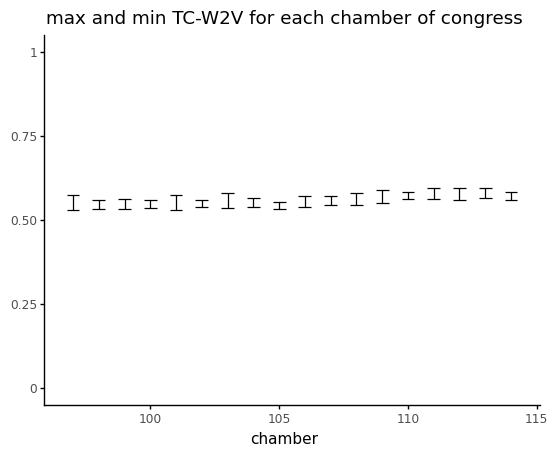

<ggplot: (-9223363272920668861)>

In [25]:
(
    ggplot(max_min_cngress_w2v,aes(x = 'chamber')) +
    geoms.geom_errorbar(aes(ymin='congress_w2v_y',ymax='congress_w2v_x')) +
    ylim(0,1) +
    theme_classic() +
    ggtitle('max and min TC-W2V for each chamber of congress')
)

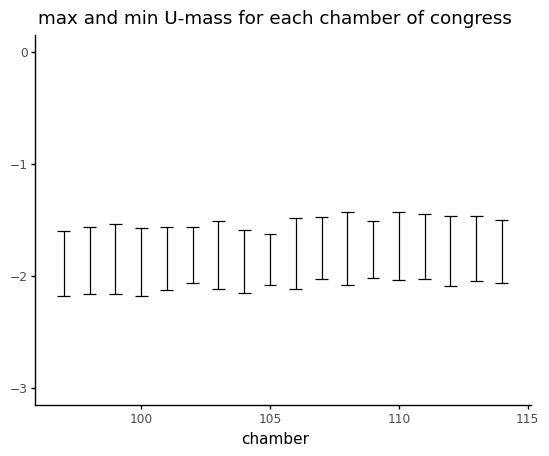

<ggplot: (-9223363272920857007)>

In [35]:
max_min_cngress_umass = combined.groupby('chamber')['u_mass'].max().reset_index().merge(combined.groupby('chamber')['u_mass'].min().reset_index(),on='chamber')
(
    ggplot(max_min_cngress_umass,aes(x = 'chamber')) +
    geoms.geom_errorbar(aes(ymin='u_mass_y',ymax='u_mass_x')) +
    theme_classic() +
    ggtitle('max and min U-mass for each chamber of congress') +
    ylim(-3,0)
)

#### NOTE: ultimately, there does not seem to be a meaningful amount of variation in the coherence scores over a large range

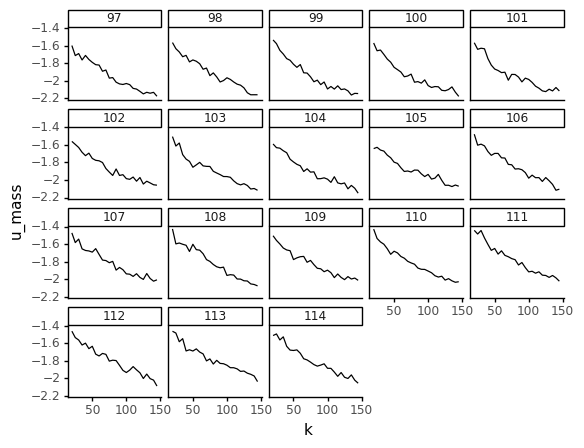

<ggplot: (-9223363272921319210)>

In [38]:
(
    ggplot(combined, aes(x = 'k',y='u_mass')) + 
    geoms.geom_line() +
    theme_classic() + 
    facet_wrap('~chamber')
)

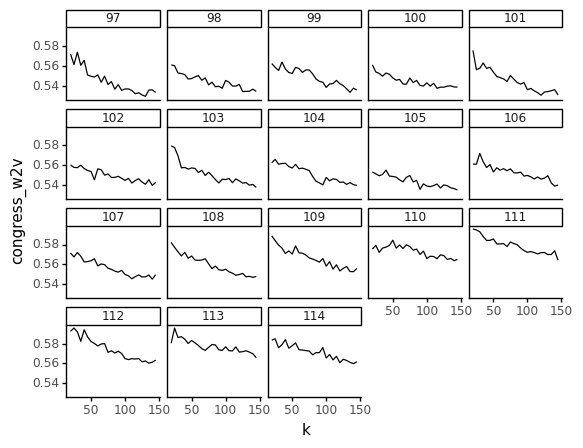

<ggplot: (-9223363272921673749)>

In [40]:
(
    ggplot(combined, aes(x = 'k',y='congress_w2v')) + 
    geoms.geom_line() +
    theme_classic() + 
    facet_wrap('~chamber')
)

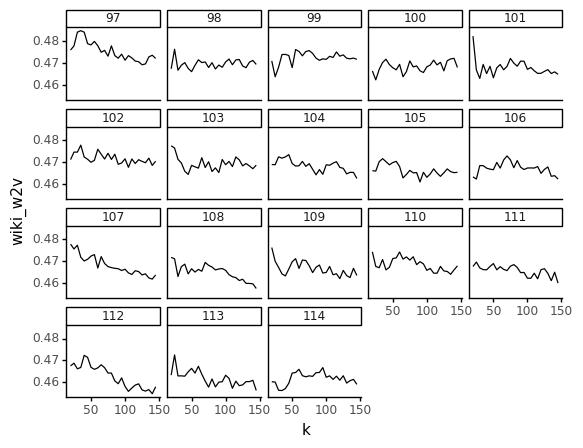

<ggplot: (-9223363272922072618)>

In [41]:
(
    ggplot(combined, aes(x = 'k',y='wiki_w2v')) + 
    geoms.geom_line() +
    theme_classic() + 
    facet_wrap('~chamber')
)